In [2]:
import os

import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from recommender import RecommendationEngine
from utils import *
from operator import itemgetter


In [3]:
def get_sales_percentage(price_list, percentage):
    # Returns a percentage of products out of all the recommended products.
    # The products are selected randomly.
    total = len(price_list)
    needed_rows = round(total * percentage / 100)

    selected_prices = []
    selected_idxs = []

    for i in range(round(needed_rows)):
        selected_idx = np.random.randint(0, total)
        while selected_idx in selected_idxs:
            selected_idx = np.random.randint(0, total)

        selected_idxs.append(selected_idx)
        selected_prices.append(price_list[selected_idx])

    return selected_prices


def get_increased_profit(
    profit_df, sales_df, users_dict, id_to_idx, sales_percentage, printing=False
):
    # Calculates the increase in profit based on users buying a percentage of
    # the recommended products
    increased_monthly_profit = profit_df.copy()
    increased_monthly_precentage = {}

    for month in sorted(sales_df["order_purchase_timestamp"].dt.month.unique()):
        ids = users_dict[month]
        # This is to prevent a corner case where one of the user IDs didn't
        # match up with any of the indexes for some reason
        try:
            idx = itemgetter(*ids)(id_to_idx)
        except KeyError as e:
            ids = list(ids)
            ids.remove(e.args[0])
            ids = itemgetter(*ids)(id_to_idx)

        item_prices = []

        for customer_idx in idx:
            # Get recommendations for a certain user
            recos, customer_id = recommendationengine.get_recommendation(
                customer_idx=customer_idx, nr_of_items=2, cluster=True
            )

            # If clustered colab filtering doesn't return any recommendations we fall back
            # on the basic colab filtering
            if recos.empty:
                recos, customer_id = recommendationengine.get_recommendation(
                    customer_idx=customer_idx, nr_of_items=2, cluster=False
                )

            item_prices.append(recos.iloc[0]["price"])

        # Since we use the 'round()' function we need more than 5 products when
        # the selection percentage is under 10%, otherwise it rounds down to 0
        # e.g: 10% of 4 products = 0.4 -> round(0.4) = 0
        # When this happens we just generate a random integer and use that as a
        if (len(item_prices) < 5) and (sales_percentage <= 10):
            random_idx = np.random.randint(0, len(item_prices))
            item_prices_percentage = [item_prices[random_idx]]
        else:
            item_prices_percentage = get_sales_percentage(item_prices, sales_percentage)

        profit_increase_percentage = (
            sum(item_prices_percentage) * 100 / profit_df[month]
        )

        if printing:
            print(f"Month: {month}")
            print(f"{profit_increase_percentage:.2f}% increase in profit")

        increased_monthly_profit[month] += sum(item_prices_percentage)
        increased_monthly_precentage[month] = profit_increase_percentage

    return increased_monthly_profit, increased_monthly_precentage


In [4]:
# Loading necessary csvs into Pandas
data_folder = "/Users/alex/Workspace/Datasets/OlistEcommercePublicDataset"

df_names = [
    "orders_df",
    "reviews_df",
    "products_df",
    "order_items_df",
    "customer_df",
    "cat_name_translation",
]
df_files = [
    "olist_orders_dataset.csv",
    "olist_order_reviews_dataset.csv",
    "olist_products_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_customers_dataset.csv",
    "product_category_name_translation.csv",
]

# Loading dataframes
dataframes = preprocess_dataframes(read_dataframes(df_names, df_files, data_folder))

# Filtering final dataframe by most active users and bought items
final_df = filter_dataframe(
    join_dataframes(dataframes), item_number=500, user_number=1000
)

# Loading translation dictionary [Portugues -> English]
translate_dict = get_translation_dict(dataframes["cat_name_translation"])

# Initializing our custom recommendation engine
recommendationengine = RecommendationEngine(
    final_df, dataframes["products_df"], dataframes["order_items_df"], translate_dict
)


In [5]:
# Converting 'order_purchase_timestamp' column to Pandas datetime
time_df = final_df.drop_duplicates(
    subset=["customer_unique_id", "product_id"]
).reset_index(drop=True)
time_df["order_purchase_timestamp"] = pd.to_datetime(
    time_df["order_purchase_timestamp"]
)
time_df.head()


,order_purchase_timestamp,customer_unique_id,product_id,price,review_score,count
0,2017-09-19 22:17:15,7973a6ba9c81ecaeb3d628c33c7c7c48,7c1bd920dbdf22470b68bde975dd3ccf,58.99,5,3
1,2018-05-11 16:35:19,831a032a3327e2b8325faf9d37953870,216bb0e0cd43ffd832e0973d35e0377e,45.00,5,6
2,2017-07-31 20:47:50,cb2d00950f18d7d8f7fcfc8cc3a173b7,389d119b48cf3043d311335e499d9c6b,59.90,3,3
3,2018-04-16 14:21:02,f8f6ed51ded0d4757a6153f5ce0f8906,10717ff440b2320081989126e858b220,138.00,4,3
4,2018-02-12 17:33:54,bf257f507db19138f5bc4065313c1f87,e53e557d5a159f5aa2c5e995dfdf244b,74.90,5,3


In [6]:
# Filtering based on year
df_2017 = time_df[time_df["order_purchase_timestamp"].dt.year == 2017]
df_2018 = time_df[time_df["order_purchase_timestamp"].dt.year == 2018]
display(df_2017.head())
display(df_2018.head())


,order_purchase_timestamp,customer_unique_id,product_id,price,review_score,count
0,2017-09-19 22:17:15,7973a6ba9c81ecaeb3d628c33c7c7c48,7c1bd920dbdf22470b68bde975dd3ccf,58.99,5,3
2,2017-07-31 20:47:50,cb2d00950f18d7d8f7fcfc8cc3a173b7,389d119b48cf3043d311335e499d9c6b,59.90,3,3
5,2017-04-03 19:07:32,3702265e16e5246cff7462ea675f6d90,c403e106353e1aa40efe783ecb39ed7a,34.90,4,4
7,2017-03-09 16:43:40,563bf685b8426233585285851fa03881,ecbe1ef7e2903ff8b1d704ba78fa264d,99.00,5,4
8,2017-11-24 19:58:16,09c361fed7245568f0f104496ed4f92f,a19b6951c75da43aad691622dd2f6abe,32.99,5,3


,order_purchase_timestamp,customer_unique_id,product_id,price,review_score,count
1,2018-05-11 16:35:19,831a032a3327e2b8325faf9d37953870,216bb0e0cd43ffd832e0973d35e0377e,45.00,5,6
3,2018-04-16 14:21:02,f8f6ed51ded0d4757a6153f5ce0f8906,10717ff440b2320081989126e858b220,138.00,4,3
4,2018-02-12 17:33:54,bf257f507db19138f5bc4065313c1f87,e53e557d5a159f5aa2c5e995dfdf244b,74.90,5,3
6,2018-03-25 16:43:56,c375736396906dff8414217e02c45661,9f1c3e71d56894398a42b050b07f1baa,11.87,3,3
10,2018-02-18 20:42:53,b08b68bac767c3269e827f822d308182,727a46f0b58a9ef165af9f7ebcfebfa9,19.49,1,5


In [7]:
# Getting the sum of all sales in each month 
monthly_profit_2017 = df_2017.groupby(df_2017["order_purchase_timestamp"].dt.month)[
    "price"
].sum()
monthly_profit_2018 = df_2018.groupby(df_2018["order_purchase_timestamp"].dt.month)[
    "price"
].sum()


In [8]:
# Generating a ID to index dictionary so we can retrieve each user's ID
id_to_idx = {}
for customer_idx in range(0, 999):
    recos, customer_id = recommendationengine.get_recommendation(
        customer_idx=customer_idx, nr_of_items=2, cluster=True
    )
    id_to_idx[customer_id] = customer_idx


In [9]:
# Finding the users that have bought items in each month
users_2017 = {}
users_2018 = {}

for month in sorted(df_2017["order_purchase_timestamp"].dt.month.unique()):
    users_2017[month] = df_2017[df_2017["order_purchase_timestamp"].dt.month == month][
        "customer_unique_id"
    ].values
for month in sorted(df_2018["order_purchase_timestamp"].dt.month.unique()):
    users_2018[month] = df_2018[df_2018["order_purchase_timestamp"].dt.month == month][
        "customer_unique_id"
    ].values


In [10]:
# sales_percentage is used to get a percentage of the items bought each month so we don't assume 
# everyone buys everything that is recommended to them.
# e.g sales_percentage=10 means take 10% of the products recommended in a month. This translates to
# assuming 10% of the recommended products have been bought
sales_percentage = 10
increased_monthly_profit_2017, increased_monthly_percentage_2017 = get_increased_profit(
    monthly_profit_2017,
    df_2017,
    users_2017,
    id_to_idx,
    sales_percentage,
    printing=False,
)
increased_monthly_profit_2018, increased_monthly_percentage_2018 = get_increased_profit(
    monthly_profit_2018,
    df_2018,
    users_2018,
    id_to_idx,
    sales_percentage,
    printing=False,
)


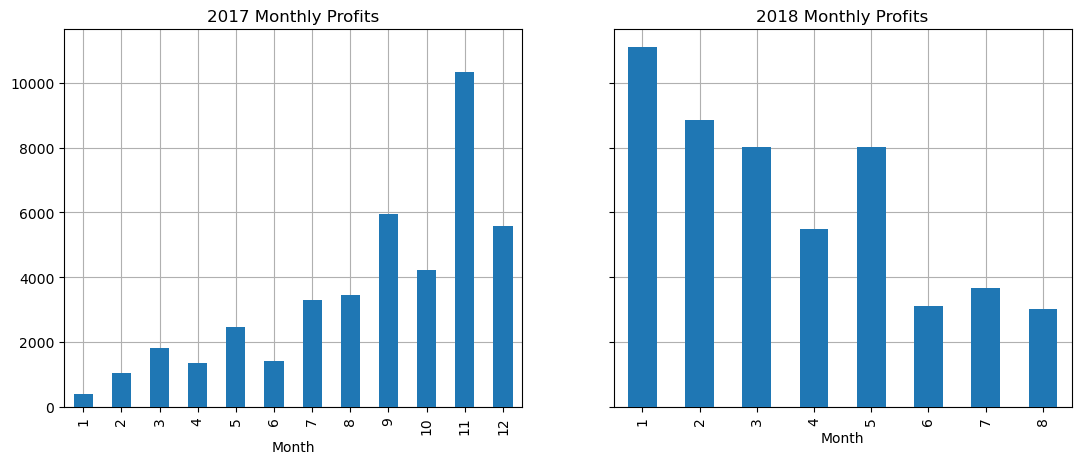

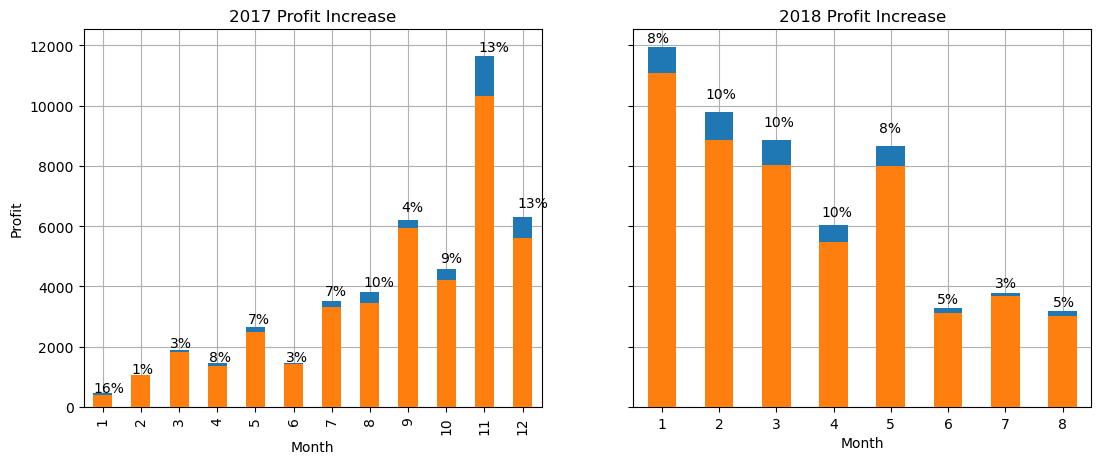

In [11]:
# Top row plots are the profits before recommender was used
# Botom row plots are sales before and after recommender was used
# plus the increase it generated

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

f, ax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(13, 5), dpi=100)

monthly_profit_2017.plot.bar(ax=ax[0], grid=True, zorder=3)
ax[0].set_title("2017 Monthly Profits")
ax[0].set_xlabel("Month")


monthly_profit_2018.plot.bar(ax=ax[1], grid=True, zorder=3)
ax[1].set_title("2018 Monthly Profits")

# f.text(0.06, 0.5, 'Profit', ha='center');
# f.text(0.51, -0.03, 'Month', ha='center');
ax[1].set_xlabel("Month")
plt.savefig('profit_initial.png')
plt.show()

f, ax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(13, 5), dpi=100)
increased_monthly_profit_2017.plot.bar(ax=ax[0], grid=True, zorder=3, color=colors[0])

for i, p in enumerate(ax[0].patches):
    perc_height = p.get_height() * 1.05

    if perc_height >= ax[0].get_ylim()[1]:
        perc_height = p.get_height() * 1.015

    ax[0].annotate(
        f"{round(increased_monthly_percentage_2017[i+1])}%",
        (p.get_x() * 1.011, perc_height),
    )

monthly_profit_2017.plot.bar(ax=ax[0], grid=True, zorder=3, color=colors[1])

ax[0].set_xlabel("Month")
ax[0].set_ylabel("Profit")
ax[0].set_title("2017 Profit Increase")

increased_monthly_profit_2018.plot.bar(ax=ax[1], grid=True, zorder=3, color=colors[0])

for i, p in enumerate(ax[1].patches):
    perc_height = p.get_height() * 1.05

    if perc_height >= ax[1].get_ylim()[1]:
        perc_height = p.get_height() * 1.015

    ax[1].annotate(
        f"{round(increased_monthly_percentage_2018[i+1])}%",
        (p.get_x() * 1.011, perc_height),
    )

monthly_profit_2018.plot.bar(ax=ax[1], grid=True, zorder=3, color=colors[1])

ax[1].set_xlabel("Month")
ax[1].set_ylabel("Profit")
ax[1].set_title("2018 Profit Increase")

plt.xticks(rotation="horizontal")
plt.savefig('profit_improvement.png')
plt.show()


In [18]:
# percentage = [round(val) for val in increased_monthly_percentage_2018.values()]
percentage = pd.Series(increased_monthly_percentage_2018).round()

increased_profit = pd.DataFrame(increased_monthly_profit_2018).reset_index()
increased_profit['type'] = 'profit'
increased_profit['percentage'] = increased_profit['order_purchase_timestamp'].map(percentage)


monthly_profit = pd.DataFrame(monthly_profit_2018).reset_index()
monthly_profit['type'] = 'revenue'

combined = pd.concat([increased_profit, monthly_profit])
combined = combined.rename(columns={'price': 'Ammount', 'order_purchase_timestamp': 'Month'})

bars = alt.Chart(combined).mark_bar(size=20).encode(
    x="Month:O",
    y="Price:N",
    color='type')

bars

alt.Chart(...)

In [ ]:
percentage = pd.Series(increased_monthly_percentage_2018).round()
percentage = (
        pd.DataFrame(percentage, columns=["Precentage of increase"])
        .reset_index()
        .rename(columns={"index": "Month"})
    )

percentage['Precentage of increase'] = percentage['Precentage of increase'].astype(int).astype(str) + "%"
percentage

,Month,Precentage of increase
0,1,7%
1,2,9%
2,3,6%
3,4,8%
4,5,9%
5,6,10%
6,7,9%
7,8,9%


In [20]:
print(id_to_idx["e89bab624ed1d8c75012bf52bacc654c"])
print(id_to_idx["ec441c1966bfa602976763f330fc5168"])

907
920
